# Central question: How can we generate images that look real?

In [10]:
import math

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [11]:
def set_seed():
    seed = 42
    torch.manual_seed(seed)

set_seed()

# Beeg data

In [12]:
batch_size=128

Why MNIST?

In [13]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

X_test = torch.Tensor( testset.data ) / 255.0# - 0.5
y_test = torch.Tensor( testset.targets ).long()
X_train = torch.Tensor( trainset.data ) / 255.0# - 0.5
y_train = torch.Tensor( trainset.targets ).long()

# train_dataset = TensorDataset(X_train, y_train)

train_data = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_data = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=True)

In [37]:
def plot_samples(samples):
    if len(samples.shape) == 4:
        flattened_samples = samples.squeeze(1)
    else: flattened_samples = samples
    
    assert flattened_samples.shape[1:] == (28, 28), ValueError

    images = flattened_samples.detach().cpu().numpy()
    
    r, c = math.ceil(math.sqrt(samples.shape[0])), math.floor(math.sqrt(samples.shape[0]))
    fig, axes = plt.subplots(r, c, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray') 
        ax.axis('off')
    plt.show()

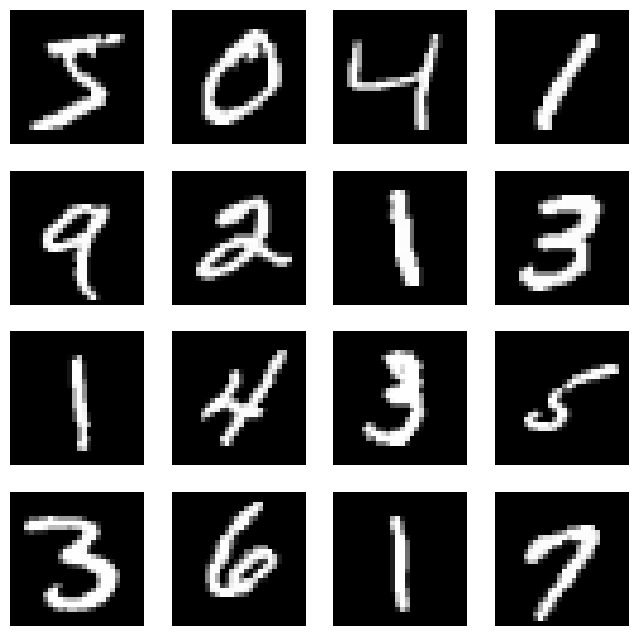

In [15]:
plot_samples(X_train[:16])

# MAchibe learnin

* Why GAN?

In [16]:
n_expansion = 64
n_latent = 64
n_channels = 1

1. Convolutional layers (regular, transpose)

2. Batch normalization: gradient descent level curves

3. Dropout: prevent overfitting in discriminator (don't want it to have accuracy 0)

4. LeakyReLU

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=n_latent, out_channels=n_expansion*8, kernel_size=4, stride=1, bias=True),
            nn.BatchNorm2d(n_expansion*8),
            nn.LeakyReLU(negative_slope=.2),

            nn.ConvTranspose2d(in_channels=n_expansion*8, out_channels=n_expansion*4, kernel_size=4, stride=2, bias=True),
            nn.BatchNorm2d(n_expansion*4),
            nn.LeakyReLU(negative_slope=.2),

            nn.ConvTranspose2d(in_channels=n_expansion*4, out_channels=n_expansion*2, kernel_size=4, stride=2, bias=True),
            nn.BatchNorm2d(n_expansion*2),
            nn.LeakyReLU(negative_slope=.2),

            nn.ConvTranspose2d(in_channels=n_expansion*2, out_channels=n_expansion, kernel_size=4, stride=1, bias=True),
            nn.BatchNorm2d(n_expansion),
            nn.LeakyReLU(negative_slope=.2),

            nn.ConvTranspose2d(in_channels=n_expansion, out_channels=1, kernel_size=4, stride=1, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, X):
        return self.layers(X)
    
def generate_samples(batch_size=256, device=device):
    return torch.randn((batch_size, n_latent, 1, 1), device=device)

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=n_expansion, kernel_size=4, stride=1, padding=0, bias=True),
            nn.LeakyReLU(negative_slope=.2),
            nn.Dropout(.4),

            nn.Conv2d(in_channels=n_expansion, out_channels=n_expansion*2, kernel_size=4, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_expansion*2),
            nn.LeakyReLU(negative_slope=.2),
            nn.Dropout(.4),

            nn.Conv2d(in_channels=n_expansion*2, out_channels=n_expansion*4, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(n_expansion*4),
            nn.LeakyReLU(negative_slope=.2),
            nn.Dropout(.4),

            nn.Conv2d(in_channels=n_expansion*4, out_channels=n_expansion*8, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(n_expansion*8),
            nn.LeakyReLU(negative_slope=.2),
            nn.Dropout(.4),

            nn.Conv2d(in_channels=n_expansion*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  
        )

    def forward(self, X):
        return self.layers(X)

Tf we need weight initialization for?
* Prevents symmetry-- each neuron won't perform the same calculation
* Gaussian distribution is good, since we can control the scale at which we normalize

In [28]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Training

Loss function
* Discriminator wants to minimize loss
* Generator wants to maximize discriminator's loss

Latent space
* Wtf is a latent space?
* Model learns to map latent space vectors to images
* Latent space interpolation

In [29]:
noise_samples = generate_samples(batch_size=16)

Train model???

In [30]:
def train_gan(D, G, lr, tolerance, patience, lim, plot=False):
    loss_function = nn.BCELoss()
    
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    N_train = len(trainset)
    N_batches_train = N_train // batch_size

    optimizer_G = optim.Adam(G.parameters(), lr=lr)
    optimizer_D = optim.Adam(D.parameters(), lr=lr)

    G_progress = []
    batch_losses_G = []
    batch_losses_D = []
    epoch_losses_G = []
    epoch_losses_D = []
    for epoch in range(lim):
        epoch_loss_G = 0
        epoch_loss_D = 0
        for X_batch, _ in train_loader:

            # Train discriminator
            
            D.zero_grad()
            optimizer_D.zero_grad()

            X_batch_real = X_batch.to(device)
            y_batch_real = torch.zeros(X_batch.shape[0]).to(device)
            y_preds_real = D(X_batch_real).view(-1)

            noise = generate_samples(batch_size=batch_size)

            X_batch_fake = G(noise)
            y_batch_fake = torch.ones(batch_size).to(device)
            y_preds_fake = D(X_batch_fake.detach()).view(-1)

            y_batch = torch.cat([y_batch_real, y_batch_fake]).to(device)
            y_preds = torch.cat([y_preds_real, y_preds_fake]).to(device)

            loss_batch_D = loss_function(y_preds, y_batch)

            loss_batch_D.backward()
            optimizer_D.step()

            epoch_loss_D += loss_batch_D.item() / N_batches_train
            batch_losses_D.append(loss_batch_D.item())

            # Train generator

            G.zero_grad()
            
            y_true_G = torch.zeros(X_batch_fake.shape[0]).to(device)
            y_preds_G = D(X_batch_fake).view(-1)

            loss_batch_G = loss_function(y_preds_G, y_true_G)

            loss_batch_G.backward()
            optimizer_G.step()

            epoch_loss_G += loss_batch_G.item() / N_batches_train
            batch_losses_G.append(loss_batch_G.item())

        print(f"Epoch {epoch}  \tD: {epoch_loss_D}; G: {epoch_loss_G}")
        epoch_losses_D.append(epoch_loss_D)
        epoch_losses_G.append(epoch_loss_G)
        G_progress.append(G(noise_samples))

        if plot:
            plot_samples(G_progress[-1])

    return G_progress, (batch_losses_D, batch_losses_G), (epoch_losses_D, epoch_losses_G)


In [31]:
# Create models
G = Generator().to(device)
D = Discriminator().to(device)

# Randomly initialize model weights
G.apply(weights_init)
D.apply(weights_init)

print(G)
print(D)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()
  )
)
Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4

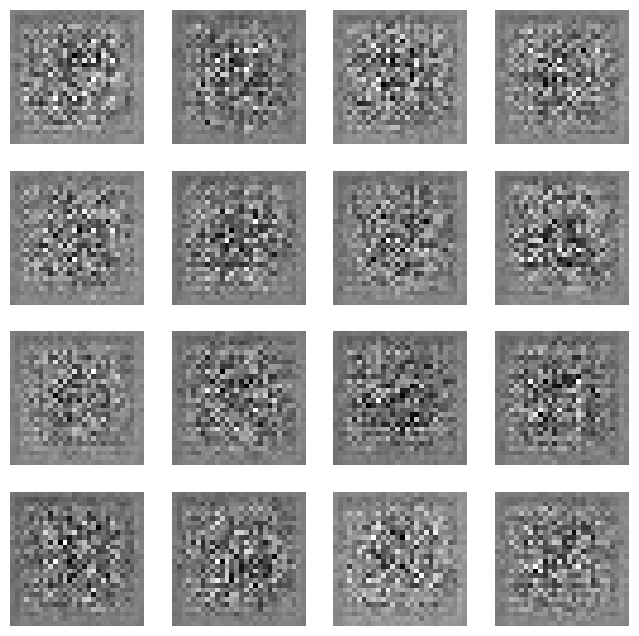

In [38]:
plot_samples(G(noise_samples))

In [39]:
lr=.001
tolerance=.01
patience=10
lim=32
plot=True

hyperparams = {
    'lr': lr,
    'tolerance': tolerance,
    'patience': patience,
    'lim': lim,
    'plot': True,
}

Epoch 0  	D: 0.3852870140750058; G: 5.305886069169409


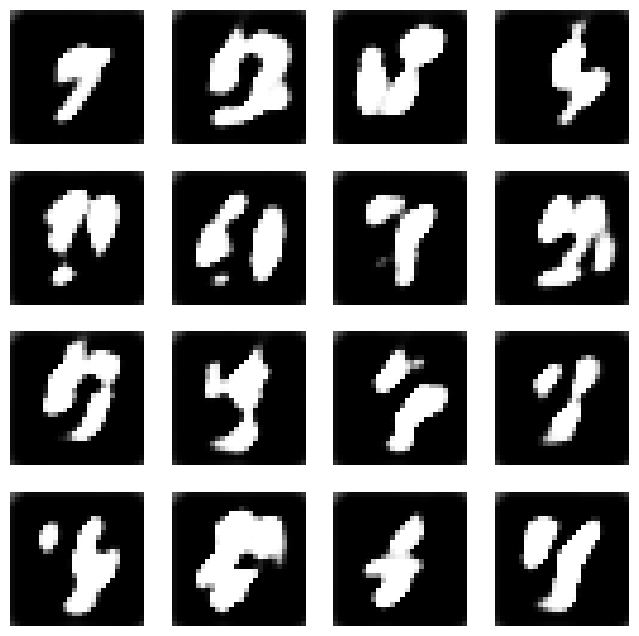

Epoch 1  	D: 0.1345100556739057; G: 5.213313254026267


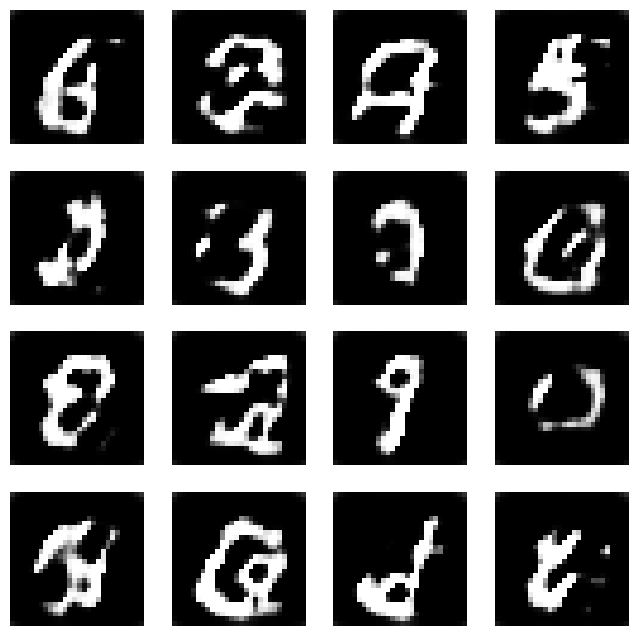

Epoch 2  	D: 0.1598301451935824; G: 5.520014477845952


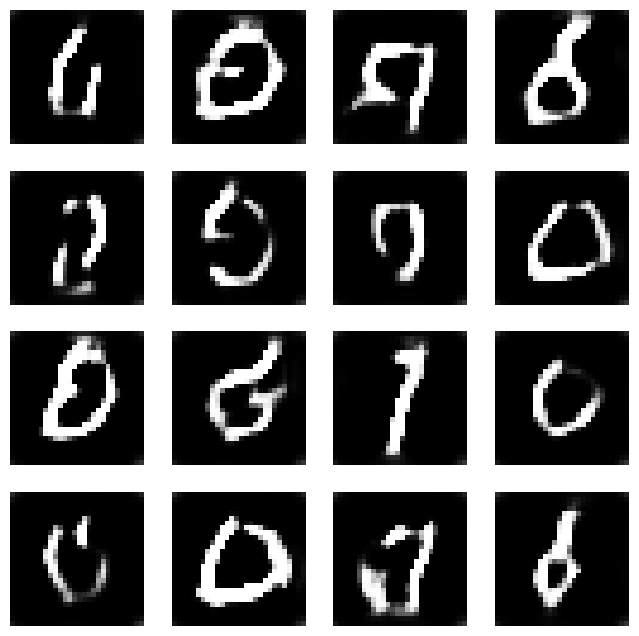

Epoch 3  	D: 0.24923805096465296; G: 5.347865073854087


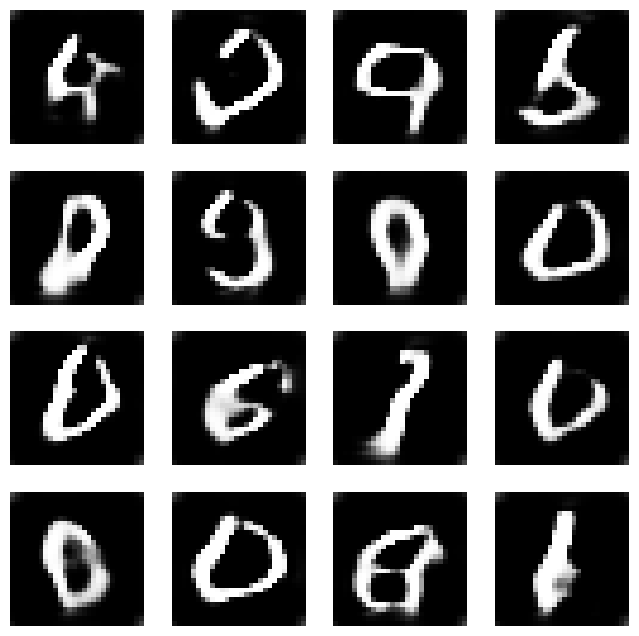

Epoch 4  	D: 0.3618191140266055; G: 3.696838263390413


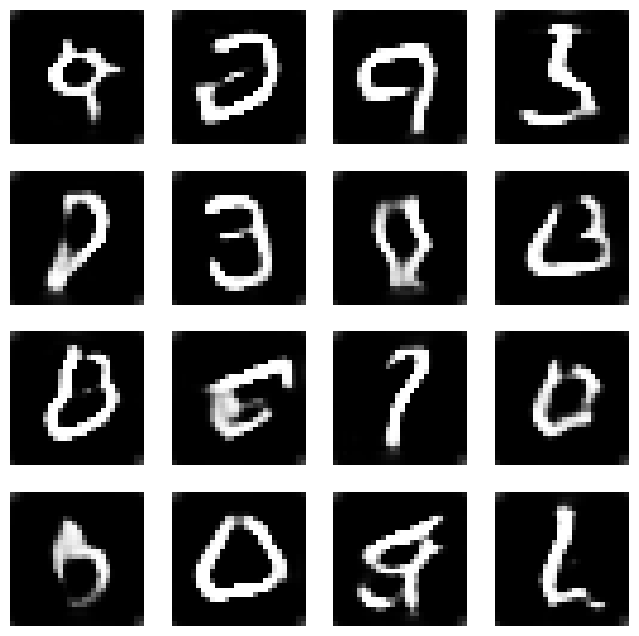

Epoch 5  	D: 0.23933420592966745; G: 4.023475901183918


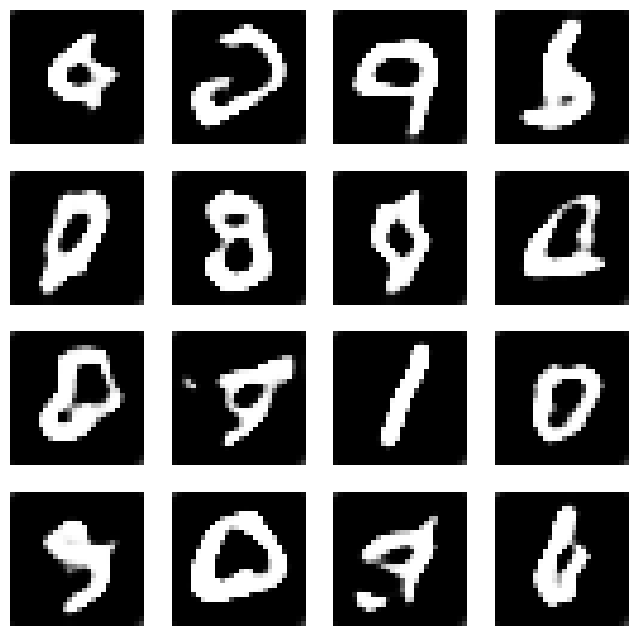

Epoch 6  	D: 0.19005165680144465; G: 4.431134054803441


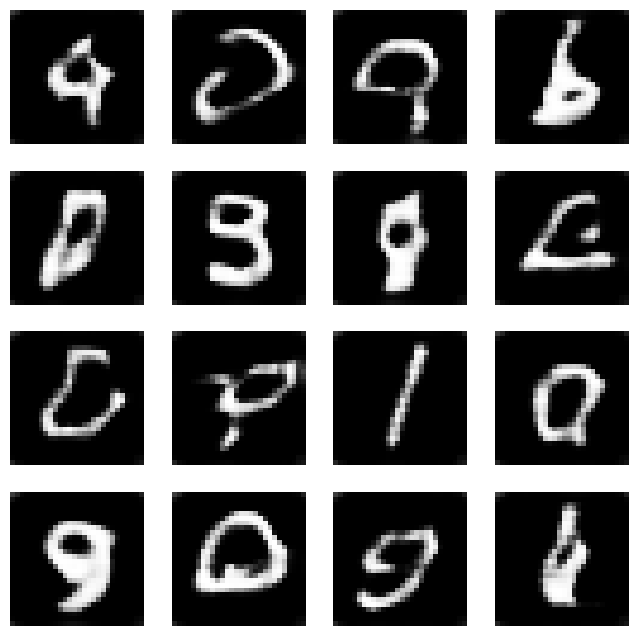

Epoch 7  	D: 0.23297116385661412; G: 4.233320211243426


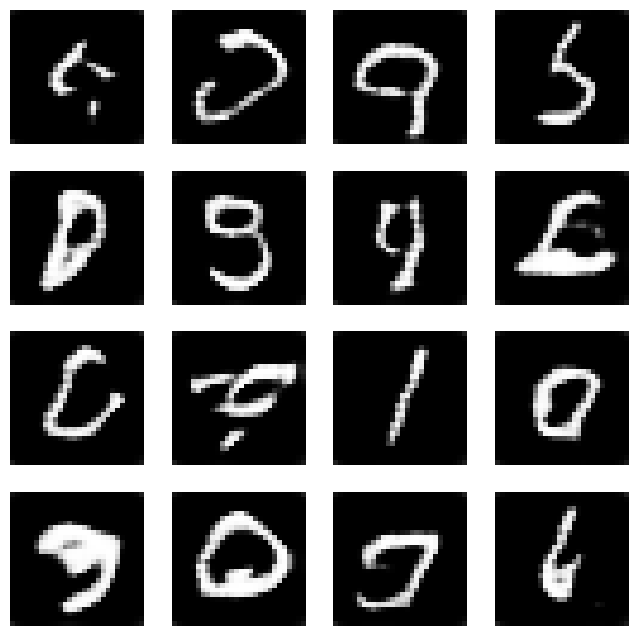

Epoch 8  	D: 0.29346044133934723; G: 3.89146479836896


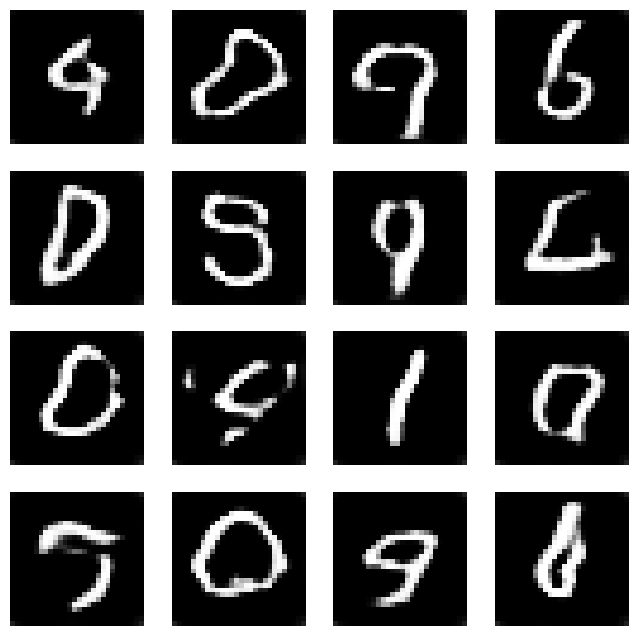

Epoch 9  	D: 0.31384226296128864; G: 3.821540226952894


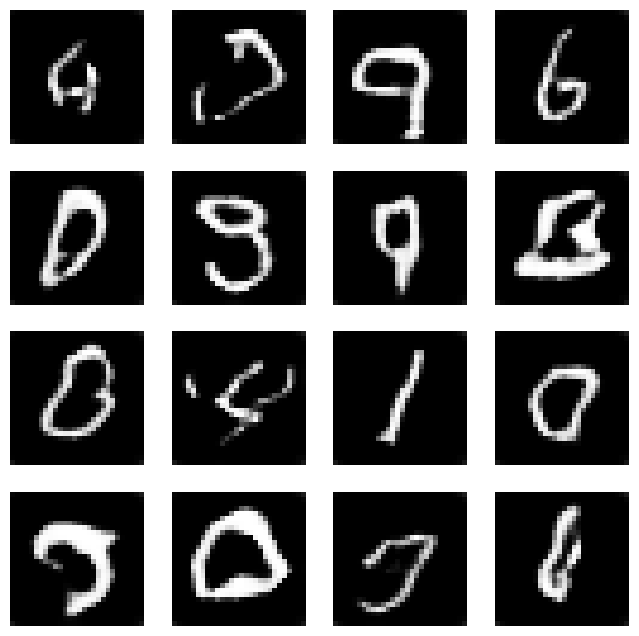

Epoch 10  	D: 0.401499142376786; G: 2.851831638660187


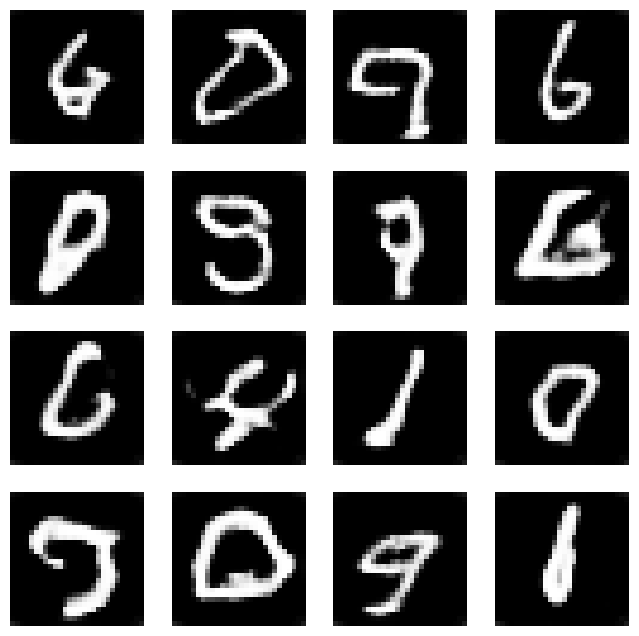

Epoch 11  	D: 0.3614589047705772; G: 2.910525278912652


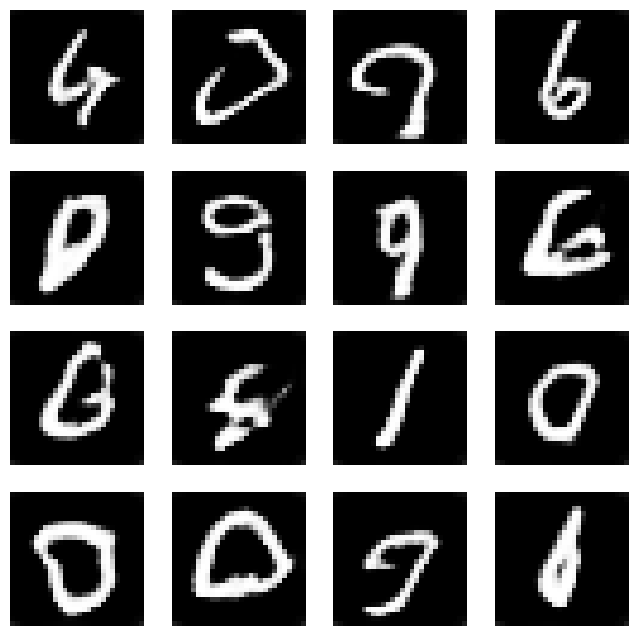

Epoch 12  	D: 0.42646009914386024; G: 2.5275364991946088


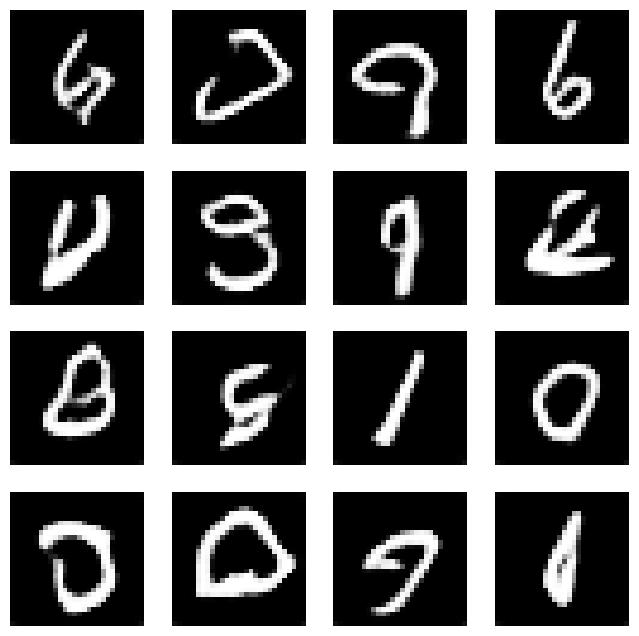

Epoch 13  	D: 0.4203740911414985; G: 2.4663137271363516


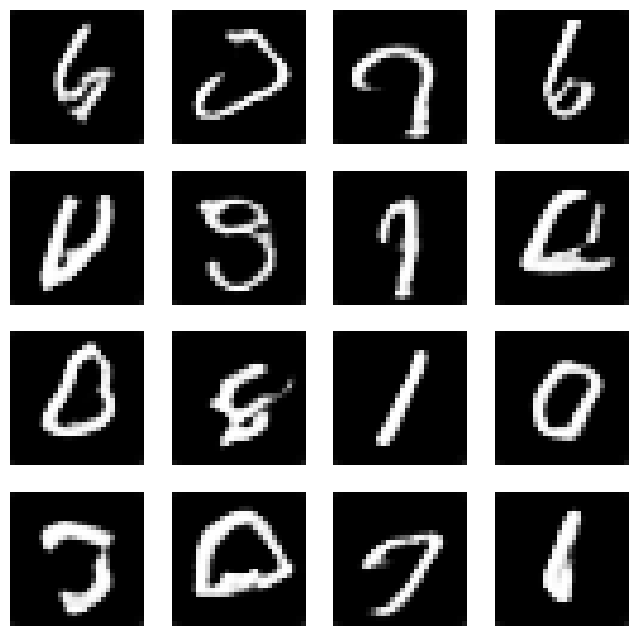

Epoch 14  	D: 0.42026613238784977; G: 2.455545865572414


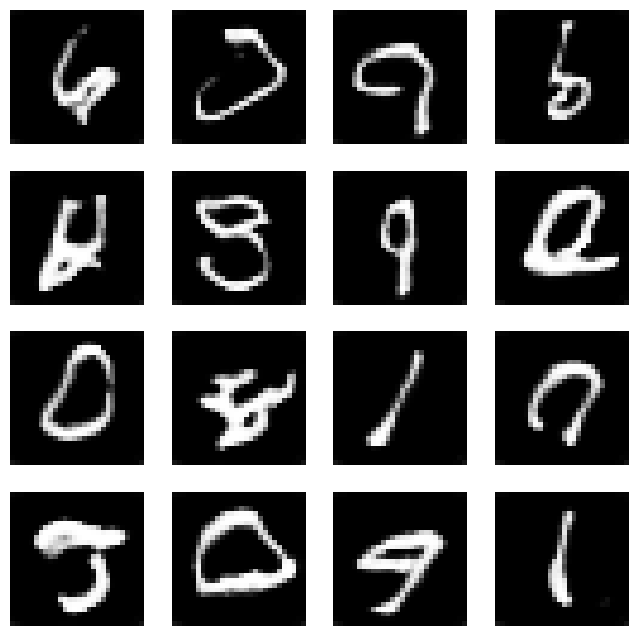

Epoch 15  	D: 0.44893923713865497; G: 2.3012893439358124


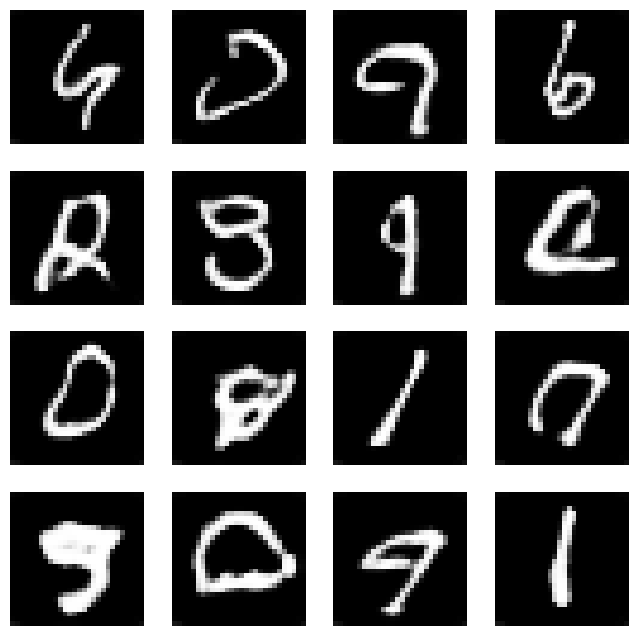

Epoch 16  	D: 0.4494353962313924; G: 2.1575999112210704


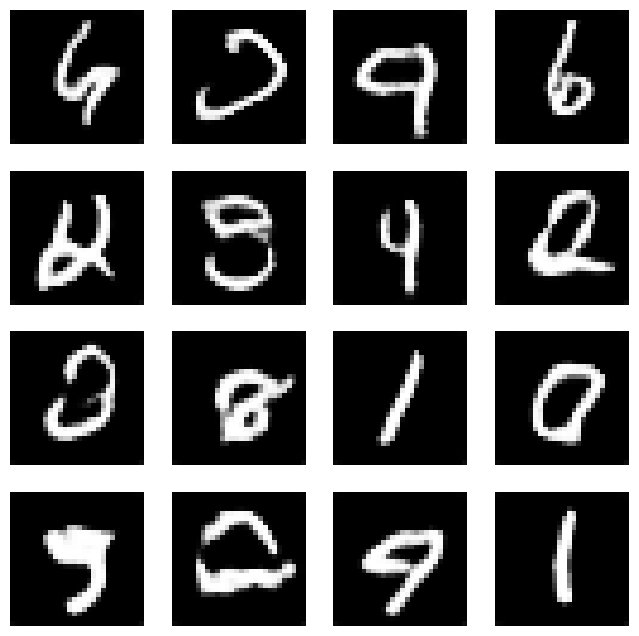

Epoch 17  	D: 0.4531525908372334; G: 2.1558061336350263


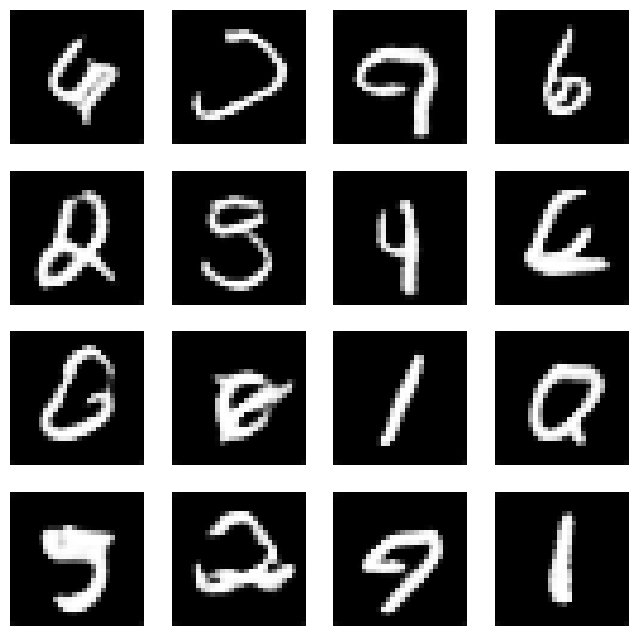

Epoch 18  	D: 0.4562158756849606; G: 2.093016683291167


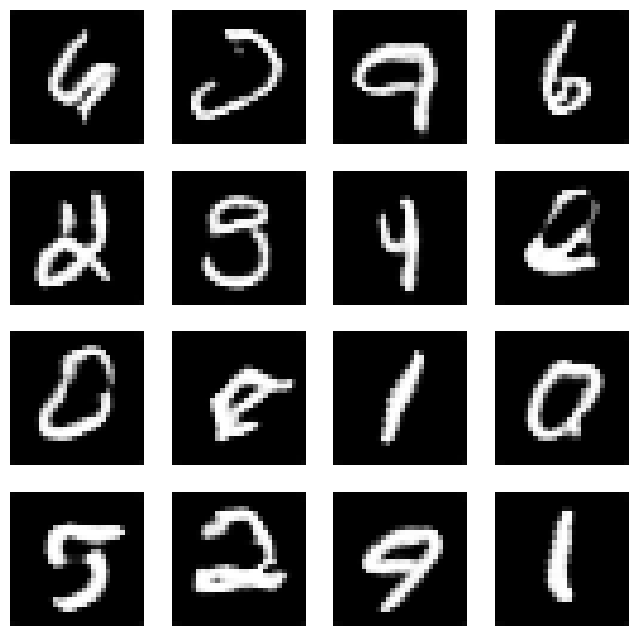

Epoch 19  	D: 0.4689440577903876; G: 2.046609266955629


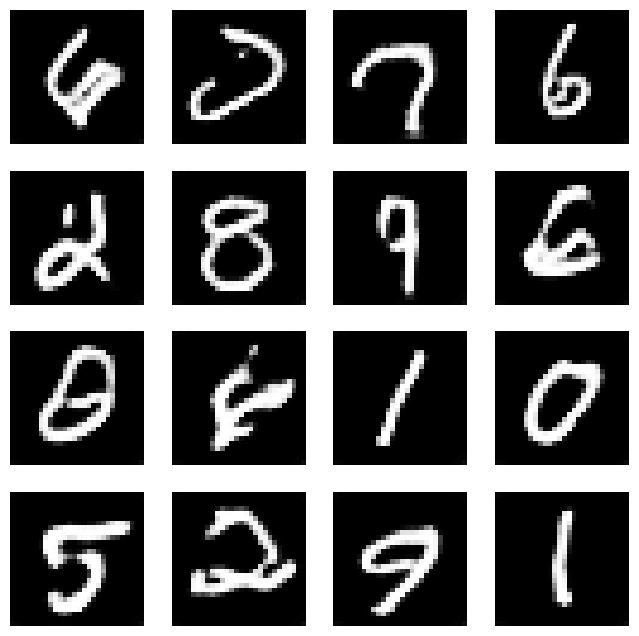

Epoch 20  	D: 0.48423353334267927; G: 1.983940465200661


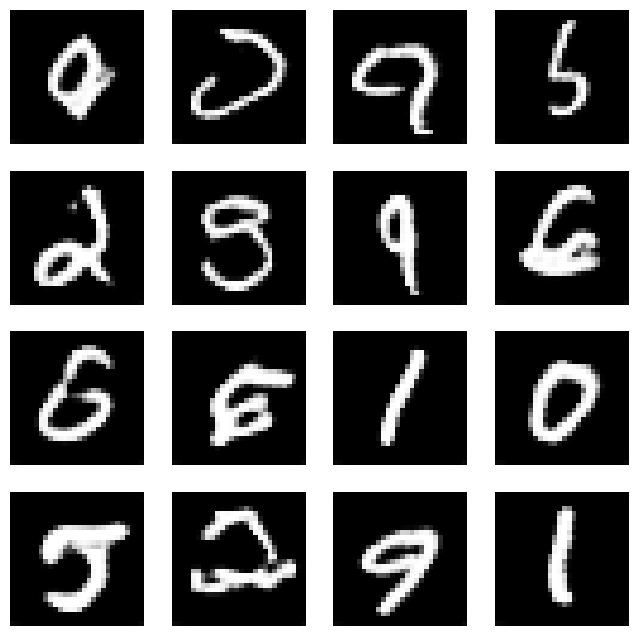

Epoch 21  	D: 0.4763751971479665; G: 1.951637274052342


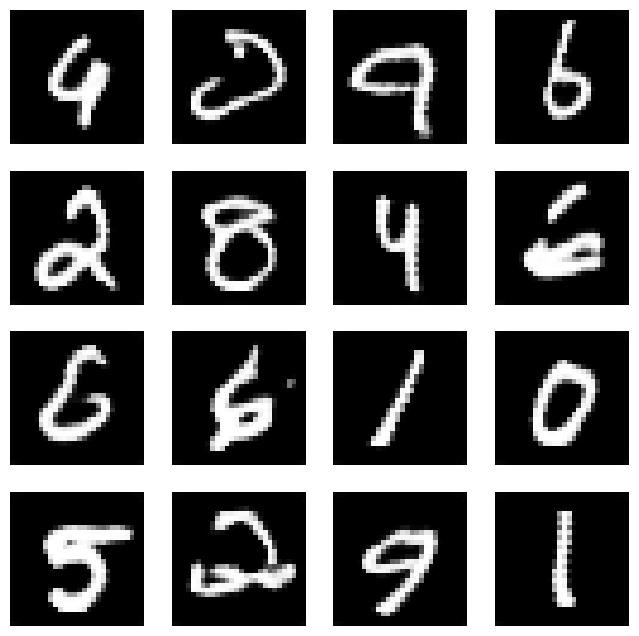

Epoch 22  	D: 0.4803354171478851; G: 1.9055750818334052


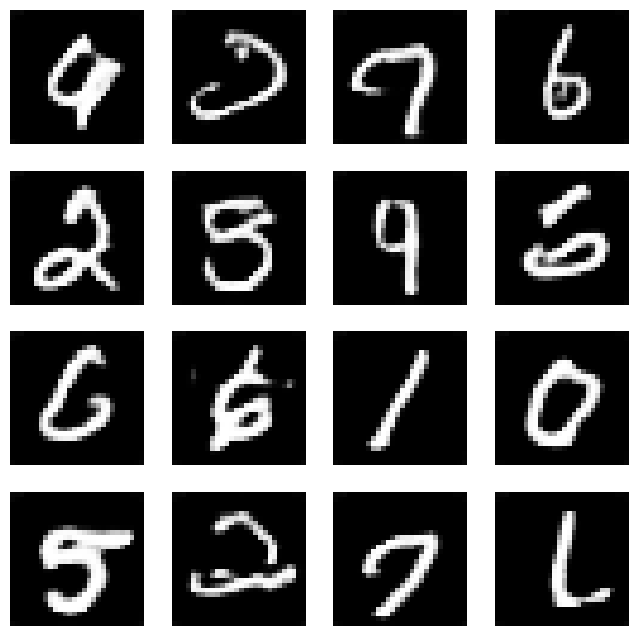

Epoch 23  	D: 0.4949461225515755; G: 1.8696312891621876


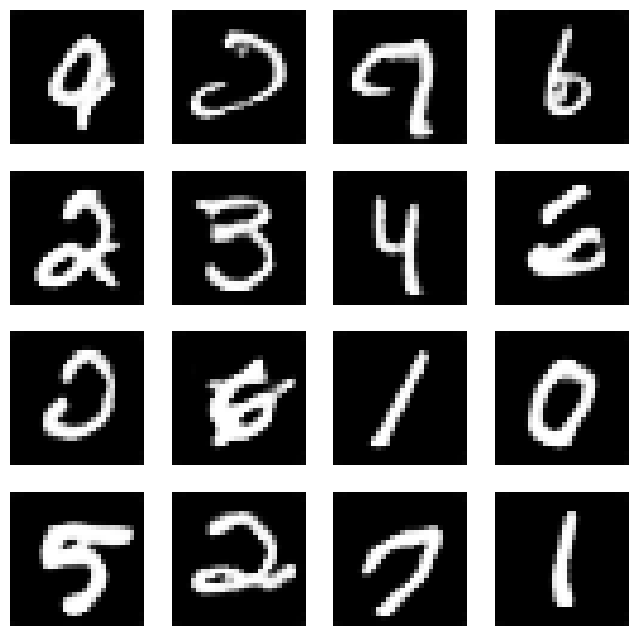

Epoch 24  	D: 0.4926045950916078; G: 1.8491478722829093


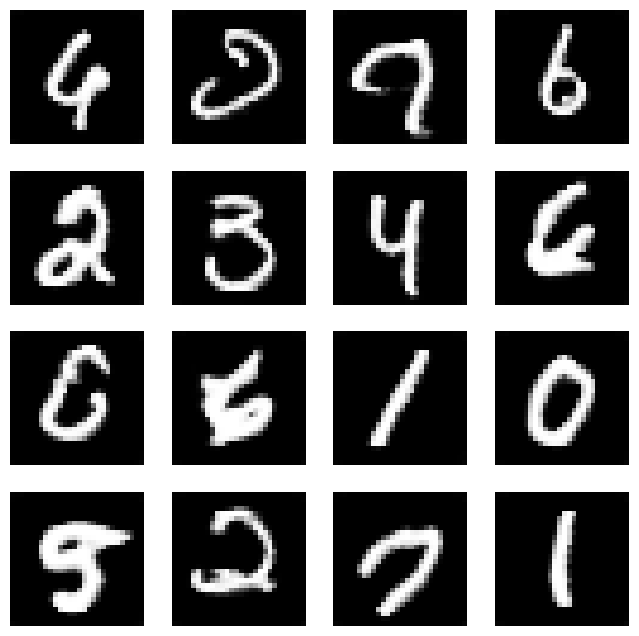

Epoch 25  	D: 0.4797141113851827; G: 1.9087536528579176


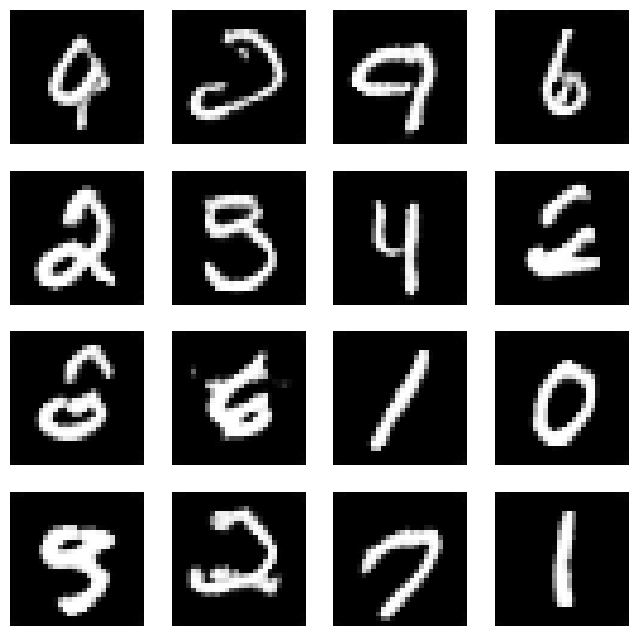

Epoch 26  	D: 0.496073763658348; G: 1.79295765258308


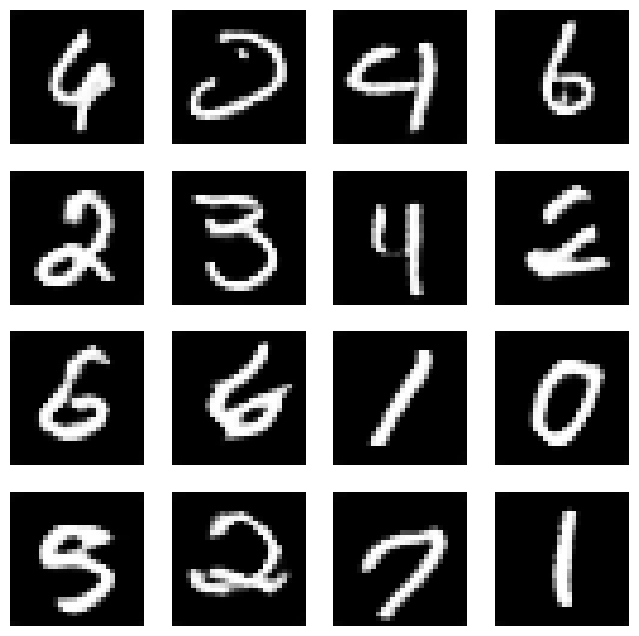

Epoch 27  	D: 0.49116116475600463; G: 1.8104802418468333


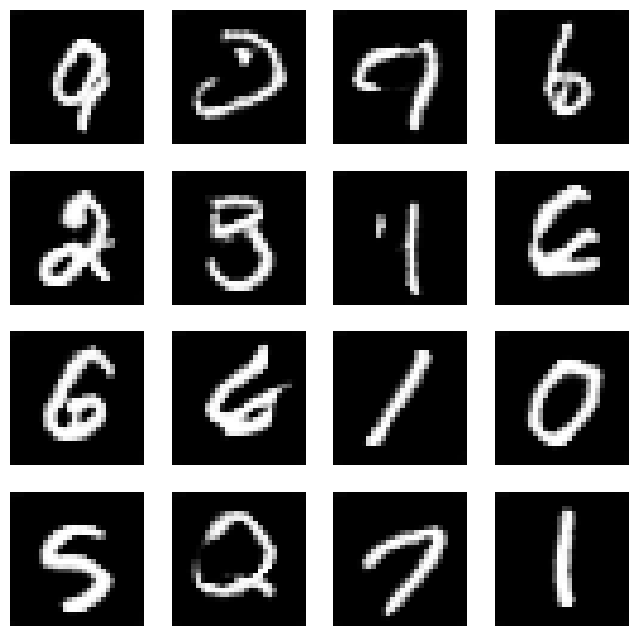

Epoch 28  	D: 0.4744610942772824; G: 1.917234684412297


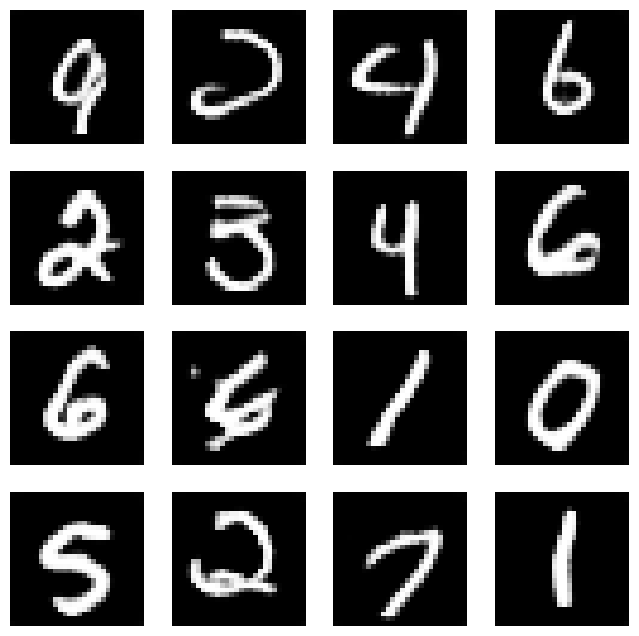

Epoch 29  	D: 0.49587541665786355; G: 1.8133293689570875


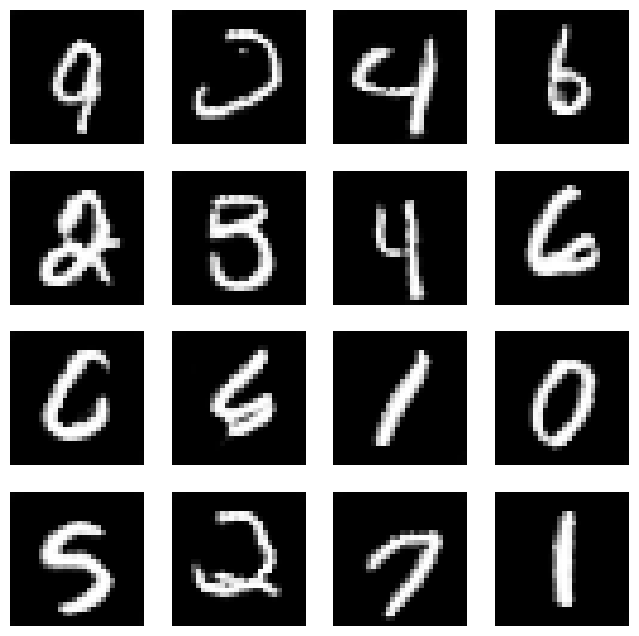

Epoch 30  	D: 0.48789074736782617; G: 1.8400435022309298


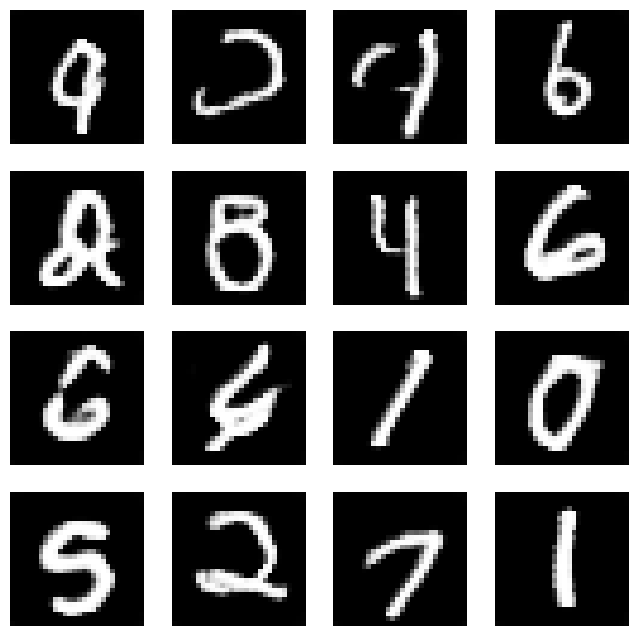

Epoch 31  	D: 0.503844760867775; G: 1.7308113538047172


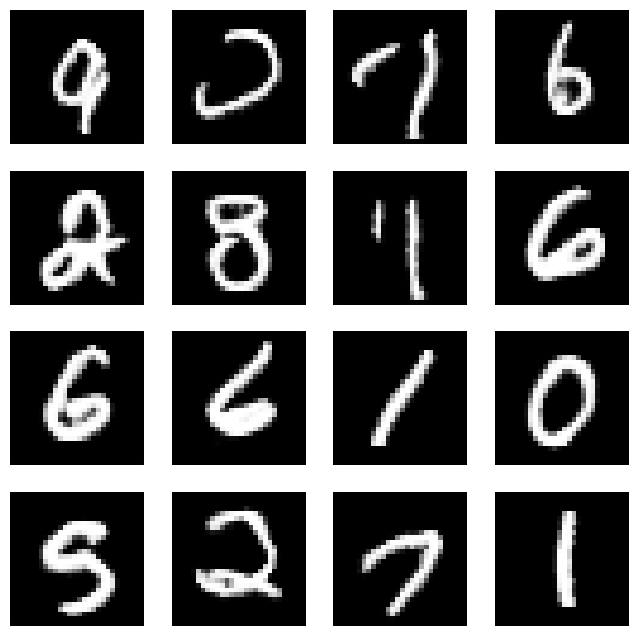

In [40]:
images, batch_losses, epoch_losses = train_gan(D, G, **hyperparams)

In [43]:
generator_path = f"models/generator.pth"
discriminator_path = f"models/discriminator.pth"

In [46]:
torch.save(G.state_dict(), generator_path)
torch.save(D.state_dict(), discriminator_path)

# How did we do?

* How can we measure this?
* Frechet Inception Distance

Intuition: use neural network to extract features, perform some statistical calculations on the extracted features of real, fake images, measure distance

We don't care about this!

In [48]:
D.load_state_dict(torch.load(discriminator_path))
G.load_state_dict(torch.load(generator_path))

D.eval()
G.eval()

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()
  )
)

## Rate on a scale from 1 to yes

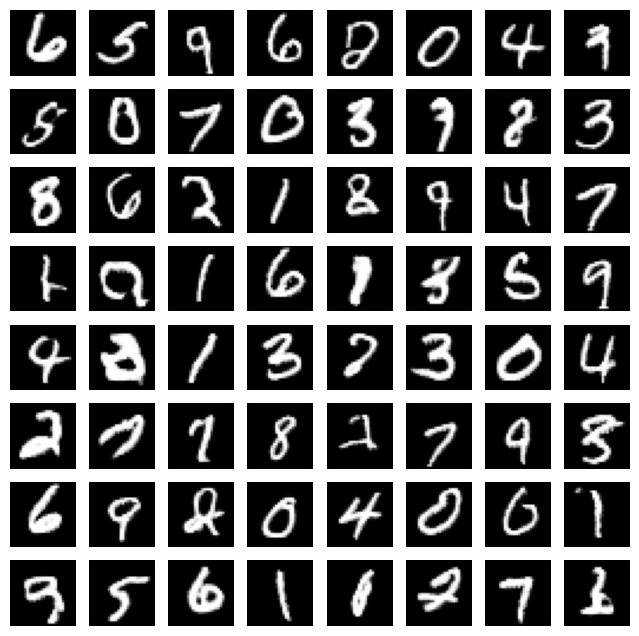

In [49]:
samples_images = G(generate_samples(64))
plot_samples(samples_images)

# Let's plot the loss!

Loss is relative!

Generator loss went down, discriminator loss went up. What does this mean?

### Batch losses

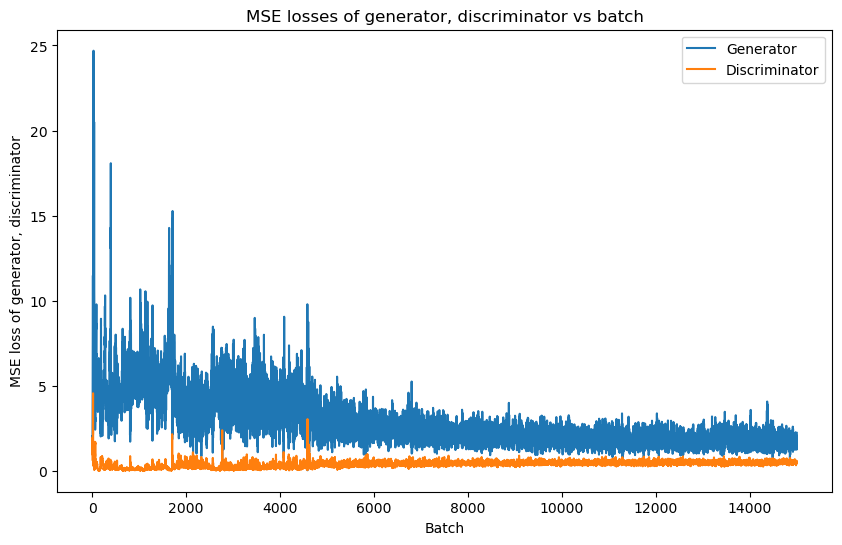

In [50]:
plt.figure(figsize=(10,6))

plt.plot(range(len(batch_losses[1])), batch_losses[1], label='Generator')
plt.plot(range(len(batch_losses[0])), batch_losses[0], label='Discriminator')

plt.xlabel('Batch')
plt.ylabel('MSE loss of generator, discriminator')
plt.title('MSE losses of generator, discriminator vs batch')

plt.legend()

plt.show()

### Epoch losses

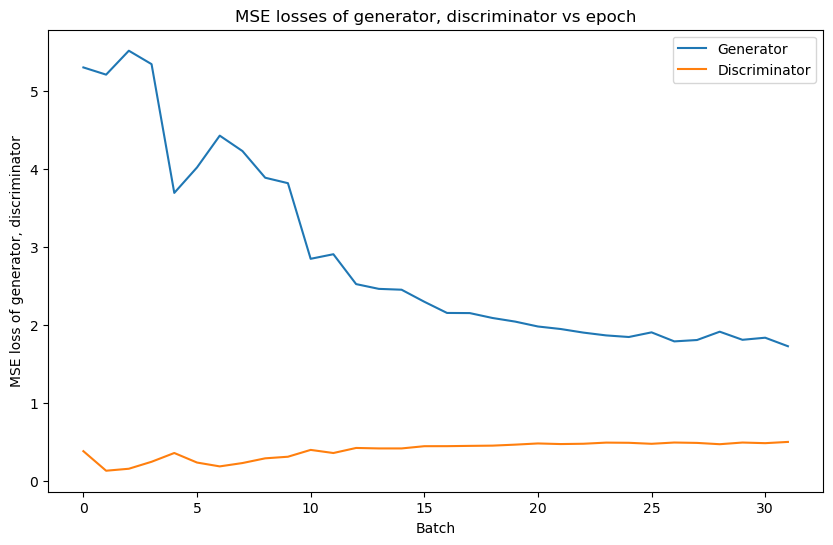

In [51]:
plt.figure(figsize=(10,6))

plt.plot(range(len(epoch_losses[1])), epoch_losses[1], label='Generator')
plt.plot(range(len(epoch_losses[0])), epoch_losses[0], label='Discriminator')

plt.xlabel('Batch')
plt.ylabel('MSE loss of generator, discriminator')
plt.title('MSE losses of generator, discriminator vs epoch')

plt.legend()

plt.show()

# Upshot

* Didn't train for 100 epochs due to time, but could still improve more
* Works decently well?


* GANs have noisy training
* Each component is limited by the other
* Can't control what digit we want to generate
* If the digit is wrong, we have no way of correcting it

# Where to go from here?

* Conditional GAN
* Self-attention
* Other generative models (VAE, Diffusion)